In [2]:
%run ../scripts/notebook_settings_lean.py
from glob import glob
import os
import zarr
import allel

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep=" ")
meta_data_samples["simple_pop"] = [x.split(",")[0].replace(" ", "_") for x in meta_data_samples.Origin]
meta_data_samples.simple_pop.unique()

array(['Mikumi', 'Aberdare', 'Chunga', 'captive', 'Awash', 'Serengeti',
       'Arusha', 'Ngorongoro', 'Ruaha', 'Gombe', 'Udzungwa', 'Mahale',
       'Katavi', 'Selous', 'Lake_Manyara', 'Tarangire', 'Niokolo-Koba',
       'Issa_Valley', 'Dendro_Park', 'Filoha', 'Gog_Woreda'], dtype=object)

In [4]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chr20"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt_zarr = allel.GenotypeArray(callset["calldata/GT"])
pos = allel.SortedIndex(callset["variants/POS"])

In [5]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

In [6]:
loc_region = pos.locate_range(13000000, 13200000)

IDs = meta_data_samples.loc[(meta_data_samples.Origin == "Lake Manyara, Tanzania")].callset_index.values

pos = allel.SortedIndex(callset["variants/POS"])
gt_region = allel.GenotypeArray(gt_zarr[loc_region])
gt = gt_region.take(IDs, axis=1)
ac = gt.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > len(IDs)/2)
gf = gt.compress(flt, axis=0)
gn = gf.to_n_alt()

In [13]:
window_size = 10000
out, windows, counts = allel.windowed_r_squared(pos=pos.compress(flt, axis=0).tolist(), gn=gn, size = window_size, step=1000)

<AxesSubplot:>

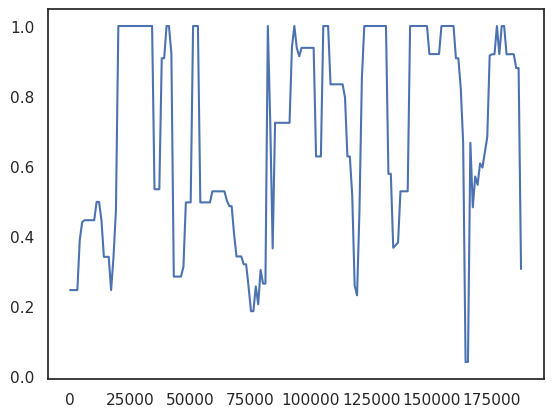

In [14]:
sns.lineplot(x=windows[:,0], y=out)

In [15]:
rmaps = glob("../smcpp_pyrho/steps/pyrho/*/*chr20*.rmap")

df_l = []
for m in rmaps:
    size = os.path.getsize(m)
    # Size check, as I had issues with the workflow.
    if size < 100:
        print(m)
        #os.remove(m)
    else:
        print(m.split("/")[-2])
        recomb_df = pd.read_csv(m, sep = "\t", names = ["start", "end", "recomb"])
        recomb_df["chrom"] = m.split("/")[-1].split(".")[0]
        recomb_df["population"] = m.split("/")[-2]
        df_l.append(recomb_df)
all_recombs = pd.concat(df_l)
all_recombs["window_size"] = all_recombs.end-all_recombs.start
all_recombs["genetic_distance"] = all_recombs.window_size*all_recombs.recomb

Katavi
Mahale
Issa_Valley
Gombe
Awash
Selous
Ngorongoro
Chunga
Tarangire
Lake_Manyara
Dendro_Park
Mikumi
Aberdare
Gog_Woreda
Niokolo-Koba
Arusha
Ruaha
captive
Filoha
Udzungwa
Serengeti


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


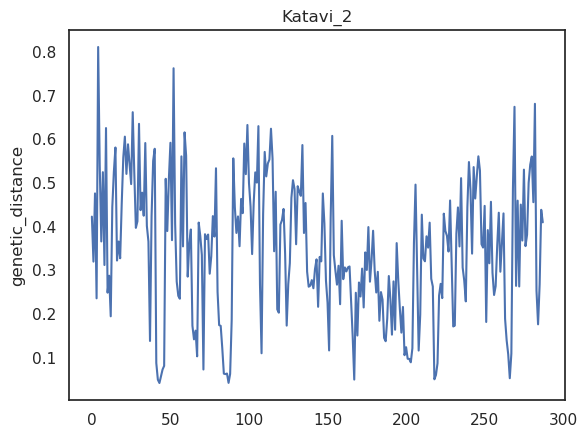

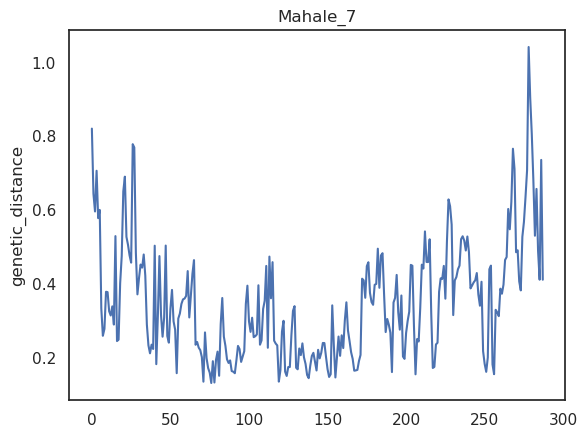

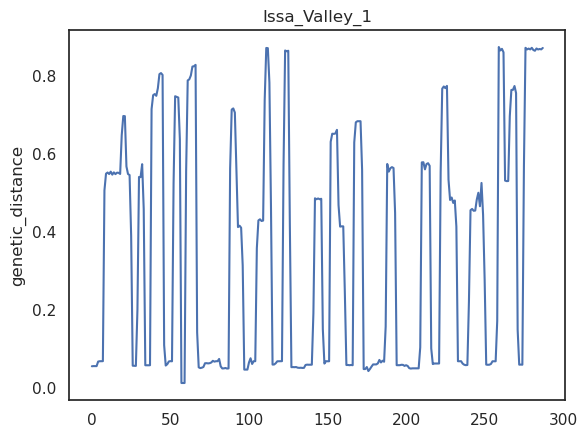

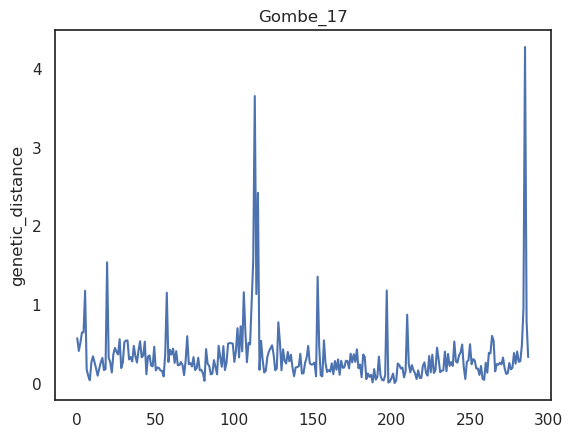

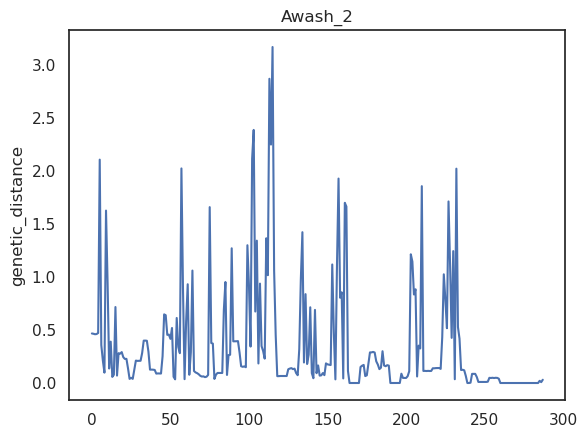

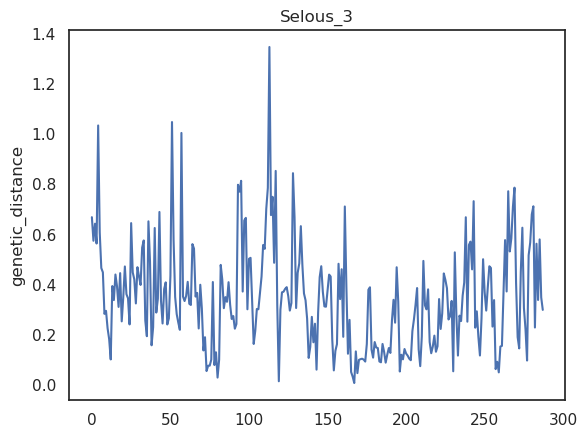

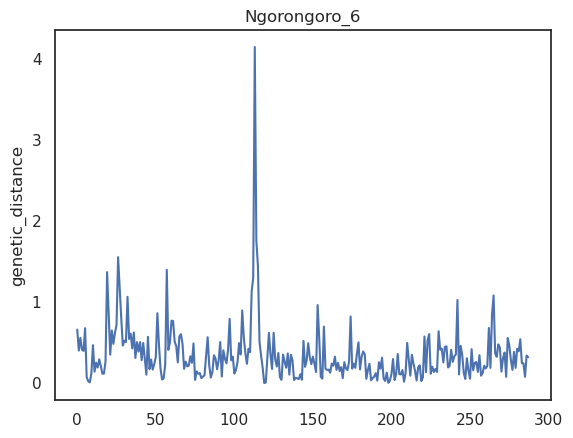

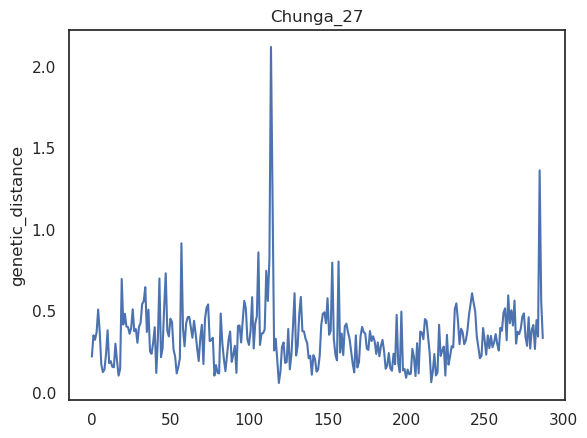

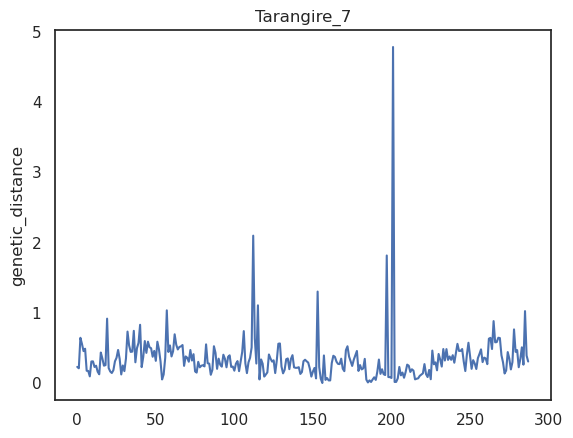

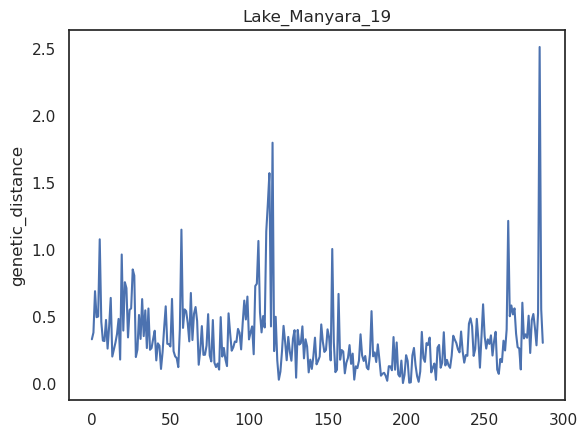

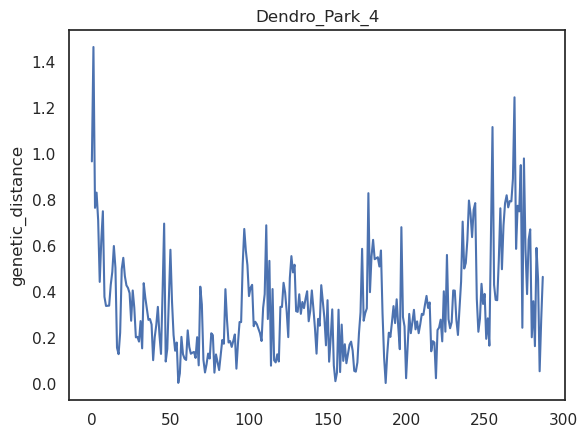

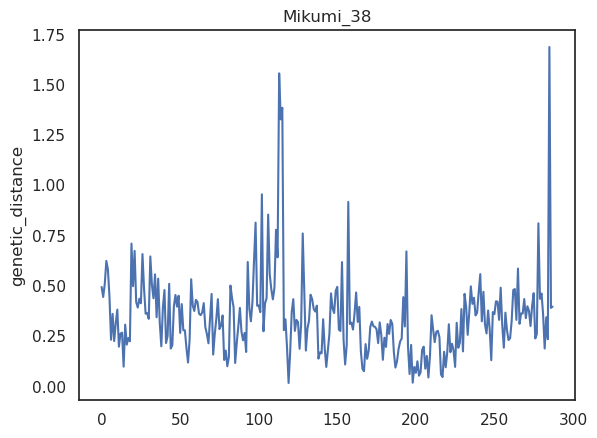

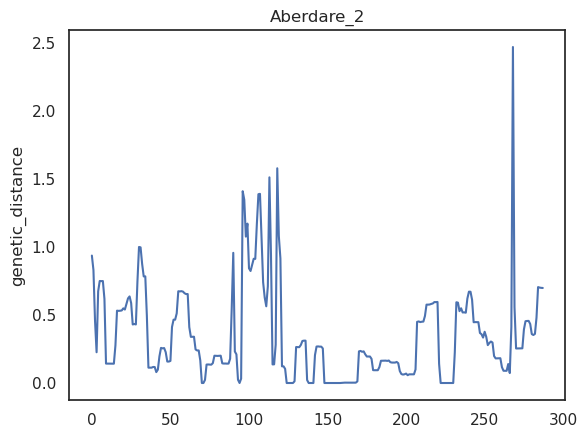

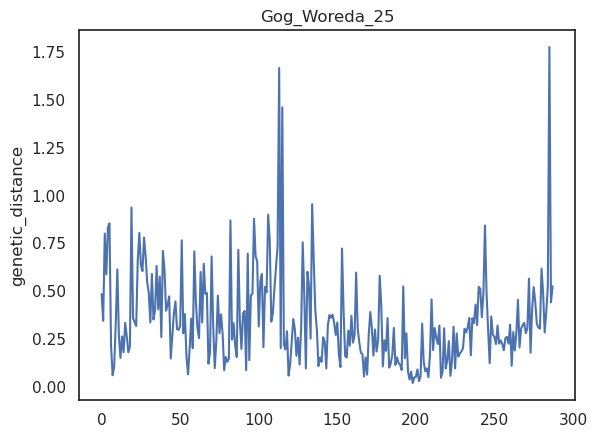

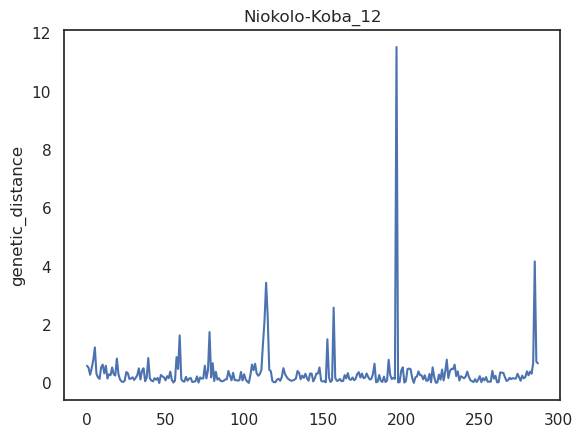

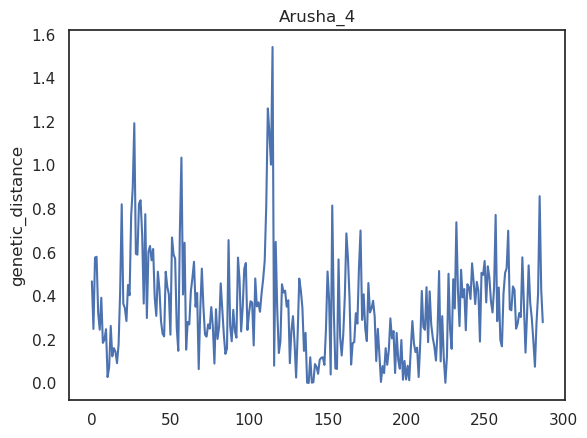

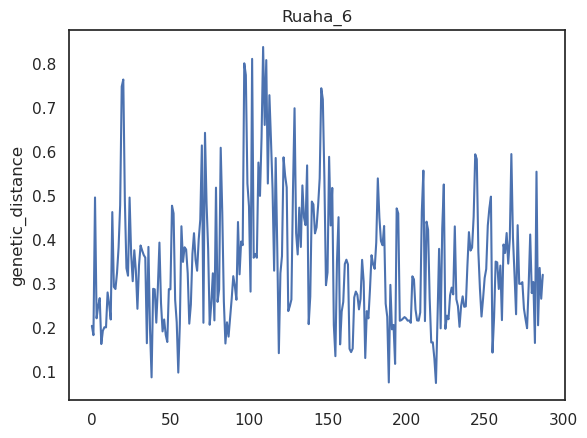

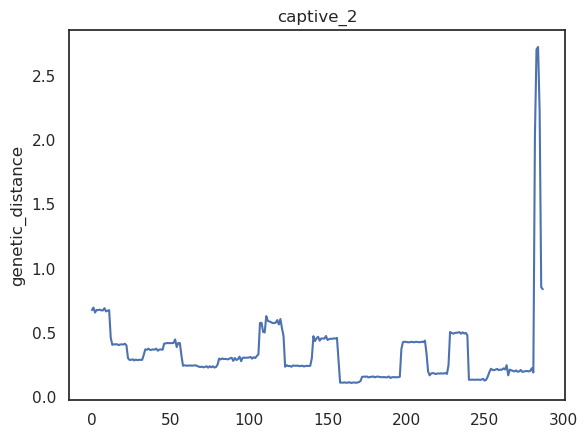

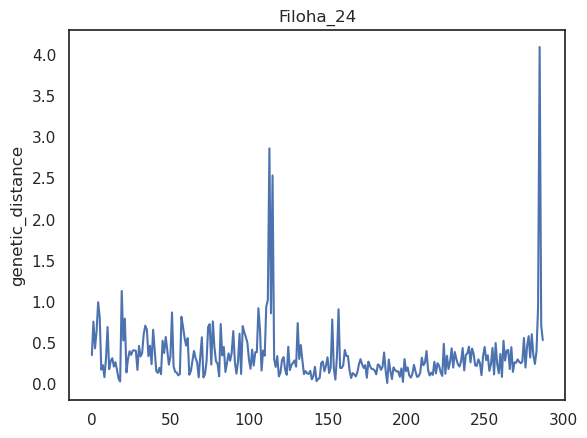

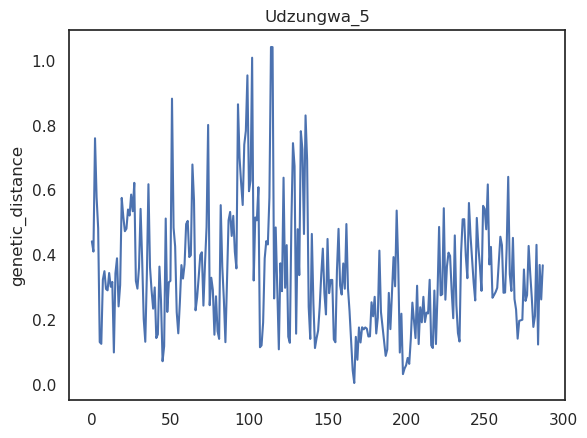

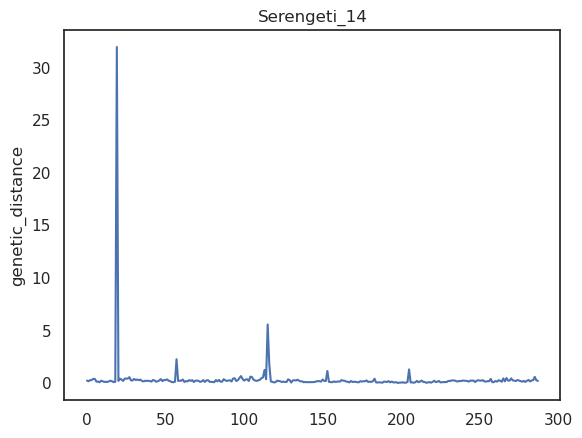

<Figure size 640x480 with 0 Axes>

In [16]:
window_size = 250000
for p in all_recombs.population.unique():
    chrom_df = all_recombs.loc[(all_recombs.chrom == "chr20") & (all_recombs.population == p)]
    total_size = chrom_df.genetic_distance.sum()
    window_sums = chrom_df.groupby(pd.cut(chrom_df.start,np.arange\
                                          (0, chrom_df.start.max(), window_size))).sum().genetic_distance*100/total_size
    fig = sns.lineplot(y = window_sums,
                x = list(range(len(window_sums))))
    sample_number = len(meta_data_samples.loc[meta_data_samples.simple_pop == p])
    fig.set(title = "{}_{}".format(p, sample_number))
    plt.figure()

In [17]:
manyara_chr20 = all_recombs.loc[all_recombs.population == "Lake_Manyara"]

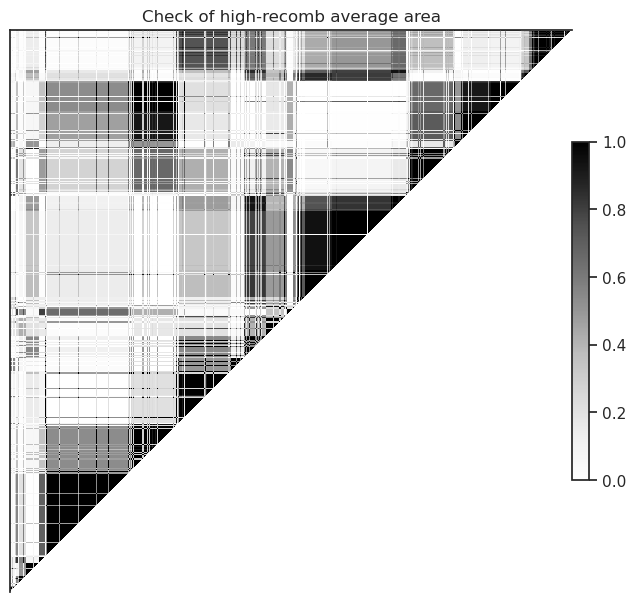

In [18]:
loc_region = pos.locate_range(13000000, 13200000)
IDs = meta_data_samples.loc[(meta_data_samples.Origin == "Lake Manyara, Tanzania")].callset_index.values

pos = allel.SortedIndex(callset["variants/POS"])
gt_region = allel.GenotypeArray(gt_zarr[loc_region])
gt = gt_region.take(IDs, axis=1)
ac = gt.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 10)
gf = gt.compress(flt, axis=0)
gn = gf.to_n_alt()
plot_ld(gn[:], 'Check of high-recomb average area')

<AxesSubplot:>

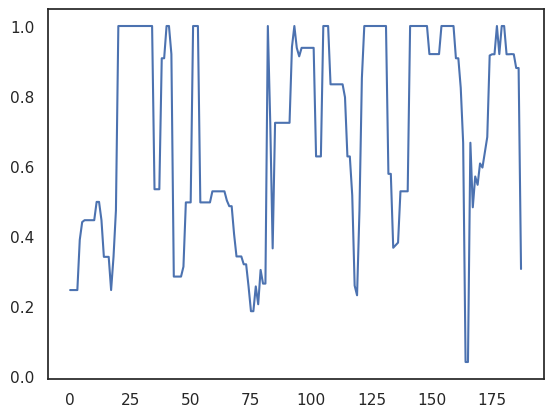

In [19]:
sns.lineplot(x=list(range(len(windows))), y=out)

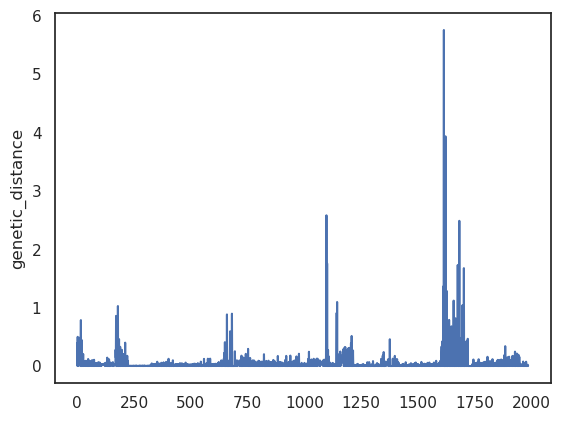

In [70]:
window_size = 100
manyara_region = manyara_chr20.loc[(manyara_chr20.start > 13000000) & (manyara_chr20.end < 13200000)]
total_size = manyara_region.genetic_distance.sum()
window_sums = manyara_region.groupby(pd.cut(manyara_region.start,np.arange\
                                          (13000000, manyara_region.start.max(), window_size))).sum().genetic_distance*100/total_size
fig = sns.lineplot(y = window_sums,
                x = list(range(len(window_sums))))

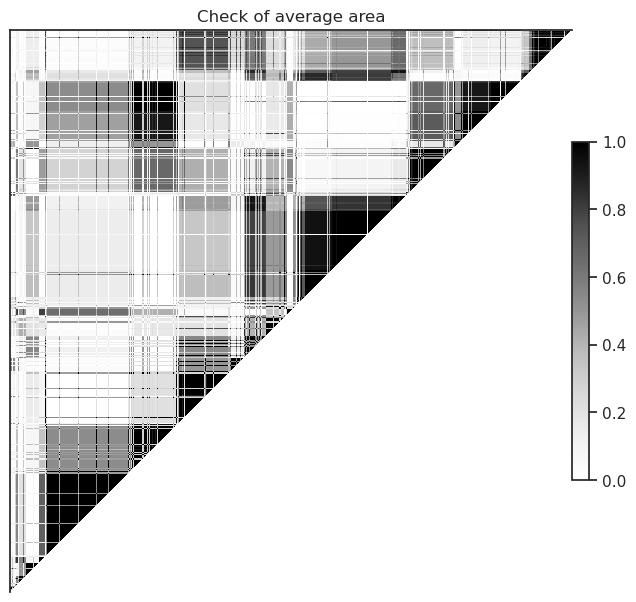

In [68]:
loc_region = pos.locate_range(13000000, 13200000)
IDs = meta_data_samples.loc[(meta_data_samples.Origin == "Lake Manyara, Tanzania")].callset_index.values

pos = allel.SortedIndex(callset["variants/POS"])
gt_region = allel.GenotypeArray(gt_zarr[loc_region])
gt = gt_region.take(IDs, axis=1)
ac = gt.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 10)
gf = gt.compress(flt, axis=0)
gn = gf.to_n_alt()
plot_ld(gn[:], 'Check of average area')

In [67]:
pos[loc_region]

0,1,2,3,4,...,8747,8748,8749,8750,8751
13000002,13000003,13000021,13000052,13000064,...,13199754,13199810,13199819,13199895,13199945


In [64]:
neighbor_lds = []
for i in range(len(gn)-1):
    neighbor_lds.append(allel.rogers_huff_r(gn[i:i+2]) ** 2)

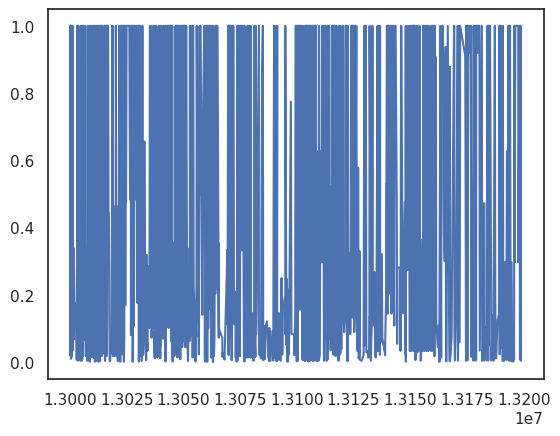

In [65]:
fig = sns.lineplot(y = neighbor_lds,
                x = pos_region[:-1])

In [66]:
pos_region

0,1,2,3,4,...,1728,1729,1730,1731,1732
13000052,13000064,13000087,13000215,13000216,...,13198601,13198607,13198681,13198849,13199415


In [61]:
manyara_region

,start,end,recomb,chrom,population,window_size,genetic_distance
103756,13000051,13000063,1.042376e-08,chr20,Lake_Manyara,12,1.250851e-07
103757,13000063,13000086,1.042376e-08,chr20,Lake_Manyara,23,2.397464e-07
103758,13000086,13000214,1.042376e-08,chr20,Lake_Manyara,128,1.334241e-06
103759,13000214,13000215,1.042376e-08,chr20,Lake_Manyara,1,1.042376e-08
103760,13000215,13000242,1.042376e-08,chr20,Lake_Manyara,27,2.814415e-07
...,...,...,...,...,...,...,...
105335,13198379,13198568,5.087990e-10,chr20,Lake_Manyara,189,9.616300e-08
105336,13198568,13198600,5.087990e-10,chr20,Lake_Manyara,32,1.628157e-08
105337,13198600,13198606,5.087990e-10,chr20,Lake_Manyara,6,3.052794e-09
105338,13198606,13198680,5.087990e-10,chr20,Lake_Manyara,74,3.765112e-08


Check of diversity and Fst

In [39]:
loc_region = pos.locate_range(13000000, 13200000)
IDs = meta_data_samples.loc[(meta_data_samples.Origin == "Lake Manyara, Tanzania")].callset_index.values

pos = allel.SortedIndex(callset["variants/POS"])
gt_region_manyara = allel.GenotypeArray(gt_zarr[loc_region]).take(IDs, axis=1)

In [40]:
loc_region = pos.locate_range(13000000, 13200000)
IDs = meta_data_samples.loc[(meta_data_samples.Origin == "Serengeti, Tanzania")].callset_index.values

pos = allel.SortedIndex(callset["variants/POS"])
gt_region_serengeti = allel.GenotypeArray(gt_zarr[loc_region]).take(IDs, axis=1)

In [41]:
gt_region_serengeti

<GenotypeArray shape=(8752, 14, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [42]:
def fst(ac1, ac2):
    num, den = allel.hudson_fst(ac1, ac2, fill=0)
    return np.sum(num) / np.sum(den)

In [43]:
out, windows, counts = allel.windowed_statistic(pos[loc_region], (gt_region_manyara.count_alleles(),
                                                                  gt_region_serengeti.count_alleles()),
                                                fst, size=window_size)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
windows

array([[13000002, 13001001],
       [13001002, 13002001],
       [13002002, 13003001],
       [13003002, 13004001],
       [13004002, 13005001],
       [13005002, 13006001],
       [13006002, 13007001],
       [13007002, 13008001],
       [13008002, 13009001],
       [13009002, 13010001],
       [13010002, 13011001],
       [13011002, 13012001],
       [13012002, 13013001],
       [13013002, 13014001],
       [13014002, 13015001],
       [13015002, 13016001],
       [13016002, 13017001],
       [13017002, 13018001],
       [13018002, 13019001],
       [13019002, 13020001],
       [13020002, 13021001],
       [13021002, 13022001],
       [13022002, 13023001],
       [13023002, 13024001],
       [13024002, 13025001],
       [13025002, 13026001],
       [13026002, 13027001],
       [13027002, 13028001],
       [13028002, 13029001],
       [13029002, 13030001],
       [13030002, 13031001],
       [13031002, 13032001],
       [13032002, 13033001],
       [13033002, 13034001],
       [130340

<AxesSubplot:>

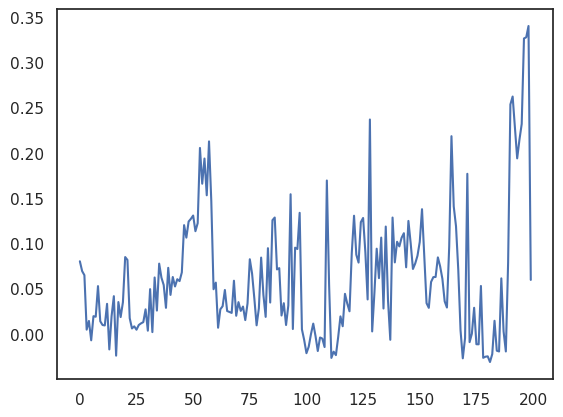

In [45]:
sns.lineplot(x=list(range(len(out))), y=out)

In [47]:
pi, windows, n_bases, counts = allel.windowed_diversity(pos[loc_region], gt_region_manyara.count_alleles(), size=window_size)

<AxesSubplot:>

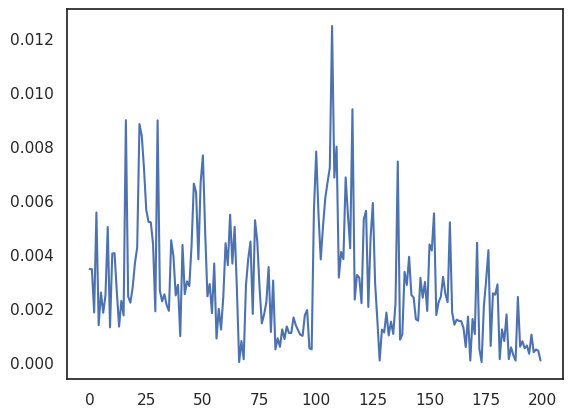

In [48]:
sns.lineplot(x=list(range(len(pi))), y=pi)

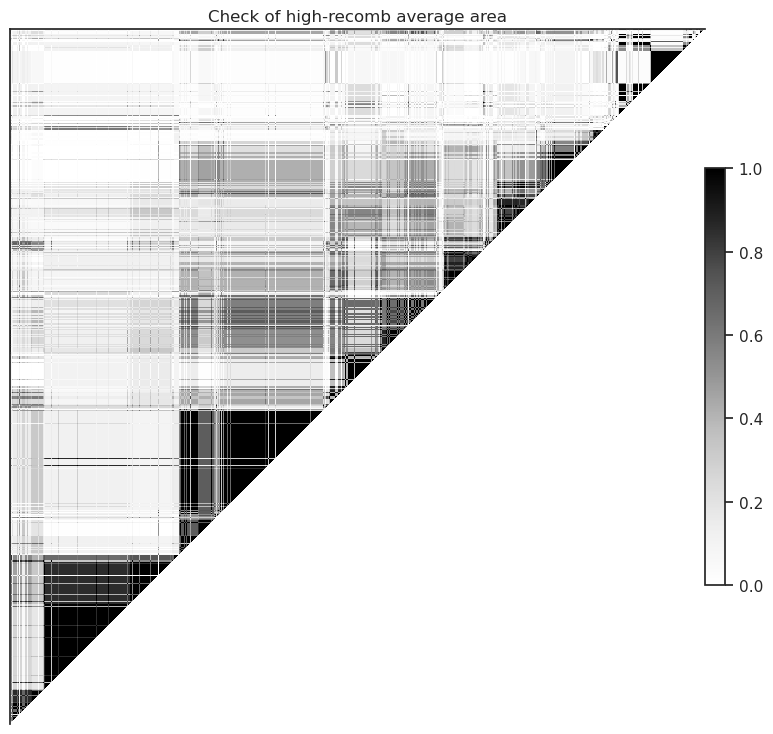

In [14]:
loc_region = pos.locate_range(13000000, 13300000)
IDs = meta_data_samples.loc[(meta_data_samples.Origin == "Serengeti, Tanzania")].callset_index.values

pos = allel.SortedIndex(callset["variants/POS"])
gt_region = allel.GenotypeArray(gt_zarr[loc_region])
gt = gt_region.take(IDs, axis=1)
ac = gt.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 9)
gf = gt.compress(flt, axis=0)
gn = gf.to_n_alt()
plot_ld(gn[:], 'Check of high-recomb average area')

Second part - comparison between various recombination maps inferred.

In [36]:
%run ../scripts/notebook_settings_lean.py
from glob import glob
from scipy import stats

In [18]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep=" ")
meta_data_samples["simple_pop"] = [x.split(",")[0].replace(" ", "_") for x in meta_data_samples.Origin]
meta_data_samples.simple_pop.unique()

array(['Mikumi', 'Aberdare', 'Chunga', 'captive', 'Awash', 'Serengeti',
       'Arusha', 'Ngorongoro', 'Ruaha', 'Gombe', 'Udzungwa', 'Mahale',
       'Katavi', 'Selous', 'Lake_Manyara', 'Tarangire', 'Niokolo-Koba',
       'Issa_Valley', 'Dendro_Park', 'Filoha', 'Gog_Woreda'], dtype=object)

In [30]:
rmaps = glob("../smcpp_pyrho/steps/pyrho/*/*chr8*.rmap")

df_l = []
for m in rmaps:
    size = os.path.getsize(m)
    # Size check, as I had issues with the workflow.
    if size < 100:
        print(m)
        #os.remove(m)
    else:
        print(m.split("/")[-2])
        recomb_df = pd.read_csv(m, sep = "\t", names = ["start", "end", "recomb"])
        recomb_df["chrom"] = m.split("/")[-1].split(".")[0]
        recomb_df["population"] = m.split("/")[-2]
        df_l.append(recomb_df)
all_recombs = pd.concat(df_l)
all_recombs["window_size"] = all_recombs.end-all_recombs.start
all_recombs["genetic_distance"] = all_recombs.window_size*all_recombs.recomb

Chunga
Mikumi
Gog_Woreda
Filoha
Serengeti


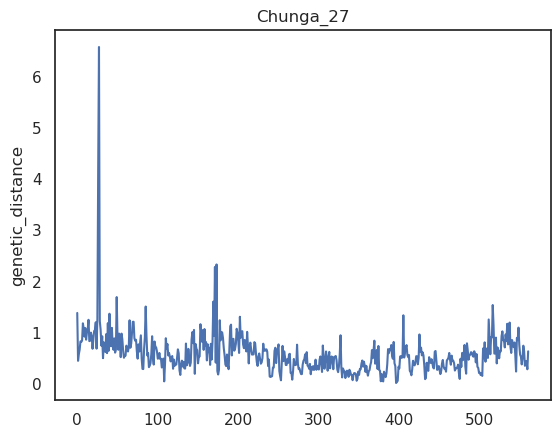

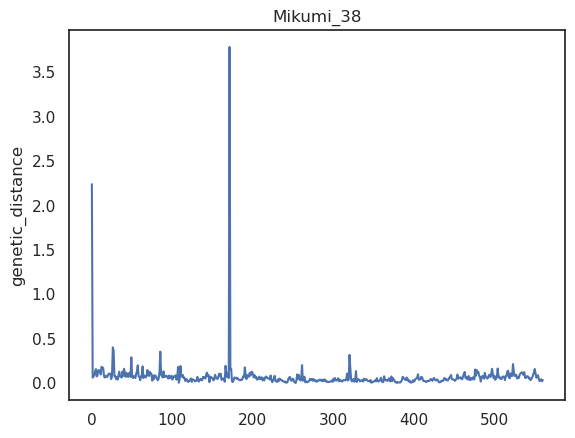

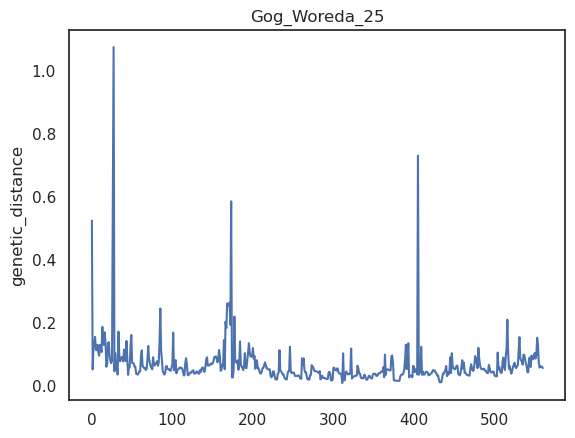

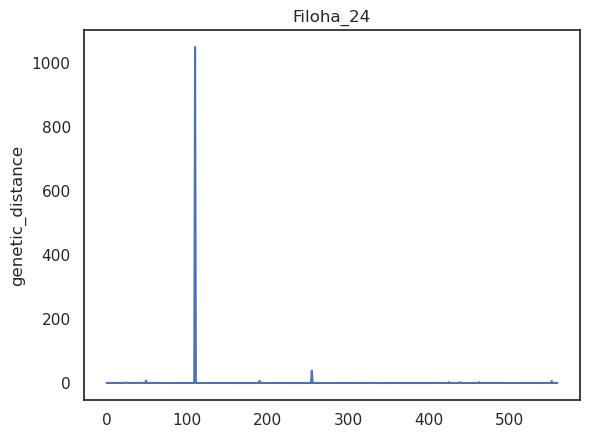

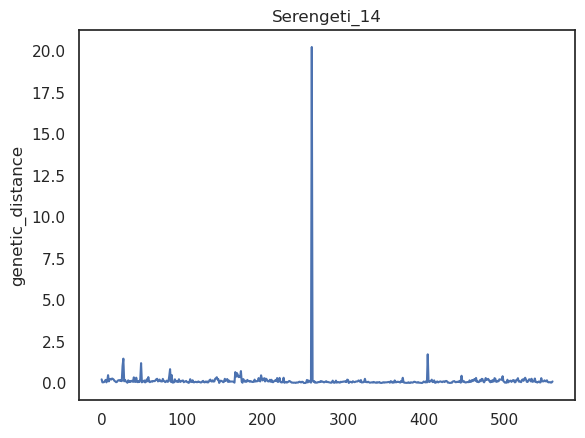

<Figure size 640x480 with 0 Axes>

In [31]:
window_size = 250000
for p in all_recombs.population.unique():
    chrom_df = all_recombs.loc[(all_recombs.population == p)]
    total_size = chrom_df.genetic_distance.sum()
    window_sums = chrom_df.groupby(pd.cut(chrom_df.start,np.arange\
                                          (0, chrom_df.start.max(), window_size))).sum().genetic_distance*100
    fig = sns.lineplot(y = window_sums,
                x = list(range(len(window_sums))))
    sample_number = len(meta_data_samples.loc[meta_data_samples.simple_pop == p])
    fig.set(title = "{}_{}".format(p, sample_number))
    plt.figure()

In [32]:
pd.qcut(window_sums, 10, labels=False)

start
(0, 250000]               8
(250000, 500000]          1
(500000, 750000]          2
(750000, 1000000]         2
(1000000, 1250000]        7
                         ..
(139000000, 139250000]    2
(139250000, 139500000]    3
(139500000, 139750000]    0
(139750000, 140000000]    1
(140000000, 140250000]    5
Name: genetic_distance, Length: 561, dtype: int64

In [84]:
# Quantile implementation

pop_list = ['Chunga', 'Mikumi',
            'Filoha', 'Gog_Woreda', 'Serengeti']

window_size = 1000000
bins = 10

array = np.ones((len(pop_list), len(pop_list)))
for i in range(len(pop_list)):
    print(pop_list[i])
    p1 = pop_list[i]
    chrom_df1 = all_recombs.loc[(all_recombs.population == p1)].sort_values(by=["chrom", "start"])
    total_size1 = chrom_df1.genetic_distance.sum()
    window_sums1 = chrom_df1.groupby(["chrom", pd.cut(chrom_df1.start,np.arange\
                                (0, chrom_df.start.max(), window_size))]).sum().genetic_distance
    qcut_1 = pd.qcut(window_sums1, bins, labels=False)
    for j in range(i):
        p2 = pop_list[j]
        chrom_df2 = all_recombs.loc[(all_recombs.population == p2)].sort_values(by=["chrom", "start"])
        print(p2, chrom_df2.chrom.unique())
        total_size2 = chrom_df2.genetic_distance.sum()
        window_sums2 = chrom_df2.groupby(["chrom", pd.cut(chrom_df2.start,np.arange\
                                (0, chrom_df.start.max(), window_size))]).sum().genetic_distance
        qcut_2 = pd.qcut(window_sums2, bins, labels=False)
        array[i][j] = (stats.pearsonr(qcut_1, qcut_2)[0])
        array[j][i] = (stats.pearsonr(qcut_1, qcut_2)[0])

Chunga


ValueError: Bin edges must be unique: array([0.        , 0.        , 0.01499641, 0.02066072, 0.02938021,
       0.12709167]).
You can drop duplicate edges by setting the 'duplicates' kwarg

['Chunga', 'Mikumi', 'Filoha', 'Gog_Woreda', 'Serengeti']


<AxesSubplot:>

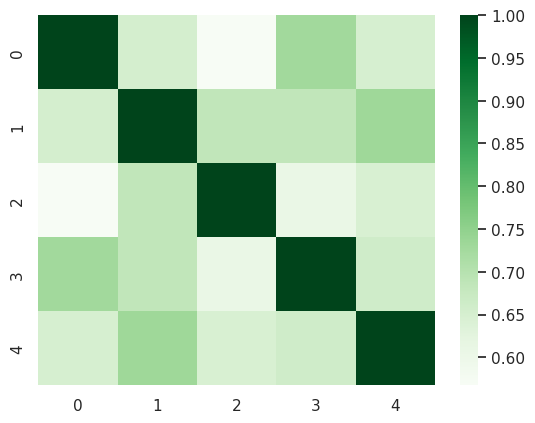

In [63]:
print(pop_list)
sns.heatmap(data=array, cmap="Greens")

In [65]:
# Rank implementation

pop_list = ['Chunga', 'Mikumi',
            'Filoha', 'Gog_Woreda', 'Serengeti']

window_size = 1000000

array = np.ones((len(pop_list), len(pop_list)))
for i in range(len(pop_list)):
    print(pop_list[i])
    p1 = pop_list[i]
    chrom_df1 = all_recombs.loc[(all_recombs.population == p1)].sort_values(by=["chrom", "start"])
    total_size1 = chrom_df1.genetic_distance.sum()
    window_sums1 = chrom_df1.groupby(["chrom", pd.cut(chrom_df1.start,np.arange\
                                (0, chrom_df.start.max(), window_size))]).sum().genetic_distance
    rank_1 = window_sums1.rank()
    for j in range(i):
        p2 = pop_list[j]
        chrom_df2 = all_recombs.loc[(all_recombs.population == p2)].sort_values(by=["chrom", "start"])
        print(p2, chrom_df2.chrom.unique())
        total_size2 = chrom_df2.genetic_distance.sum()
        window_sums2 = chrom_df2.groupby(["chrom", pd.cut(chrom_df2.start,np.arange\
                                (0, chrom_df.start.max(), window_size))]).sum().genetic_distance
        rank_2 = window_sums2.rank()
        array[i][j] = (stats.pearsonr(rank_1, rank_2)[0])
        array[j][i] = (stats.pearsonr(rank_1, rank_2)[0])

Chunga
Mikumi
Chunga ['chr8']
Filoha
Chunga ['chr8']
Mikumi ['chr8']
Gog_Woreda
Chunga ['chr8']
Mikumi ['chr8']
Filoha ['chr8']
Serengeti
Chunga ['chr8']
Mikumi ['chr8']
Filoha ['chr8']
Gog_Woreda ['chr8']


['Chunga', 'Mikumi', 'Filoha', 'Gog_Woreda', 'Serengeti']


<AxesSubplot:>

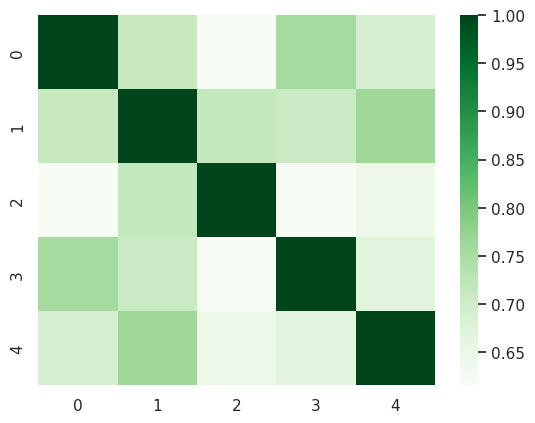

In [66]:
print(pop_list)
sns.heatmap(data=array, cmap="Greens")

In [74]:
rmaps = glob("../smcpp_pyrho/steps/pyrho/Mikumi/*.rmap")

df_l = []
for m in rmaps:
    size = os.path.getsize(m)
    # Size check, as I had issues with the workflow.
    if size < 100:
        print(m)
        #os.remove(m)
    else:
        print(m.split("/")[-2])
        recomb_df = pd.read_csv(m, sep = "\t", names = ["start", "end", "recomb"])
        recomb_df["chrom"] = m.split("/")[-1].split(".")[0]
        recomb_df["population"] = m.split("/")[-2]
        df_l.append(recomb_df)
mikumi_recombs = pd.concat(df_l)
mikumi_recombs["window_size"] = mikumi_recombs.end-mikumi_recombs.start
mikumi_recombs["genetic_distance"] = mikumi_recombs.window_size*mikumi_recombs.recomb

Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi
Mikumi


chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr3
chr4
chr5
chr6
chr7
chr8
chr9


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


chrX
flat_chr2
flat_chr3


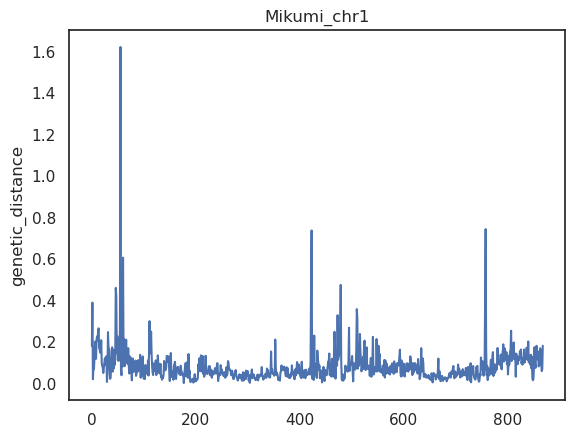

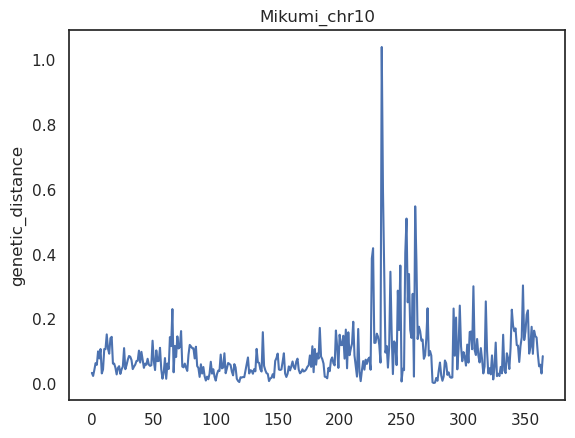

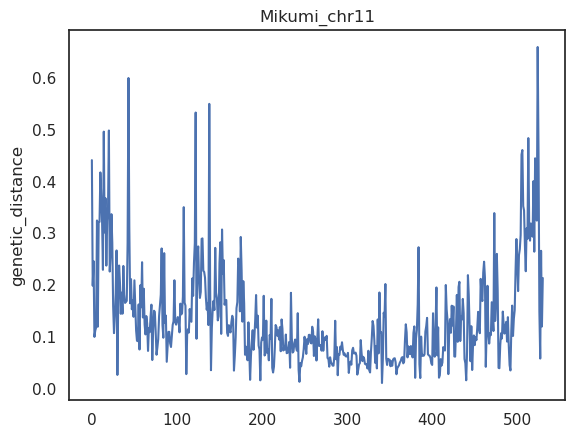

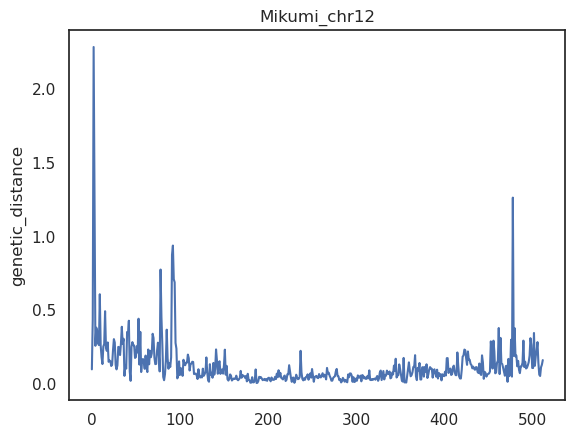

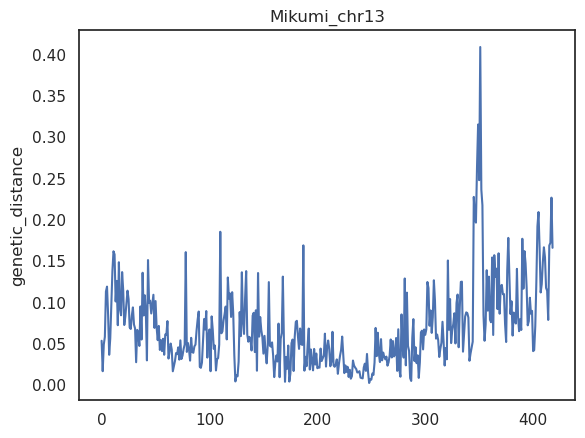

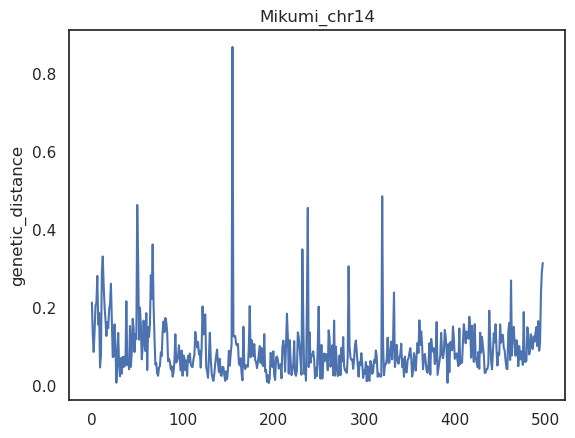

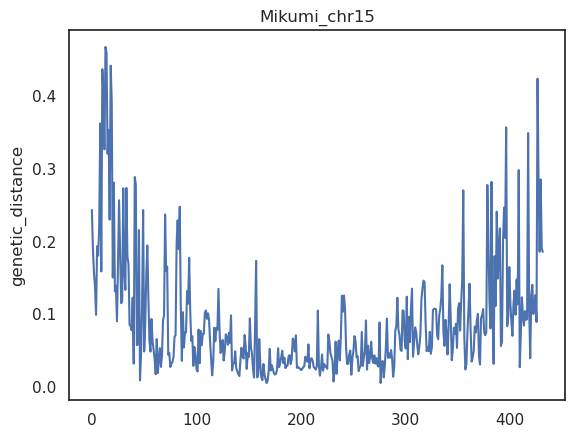

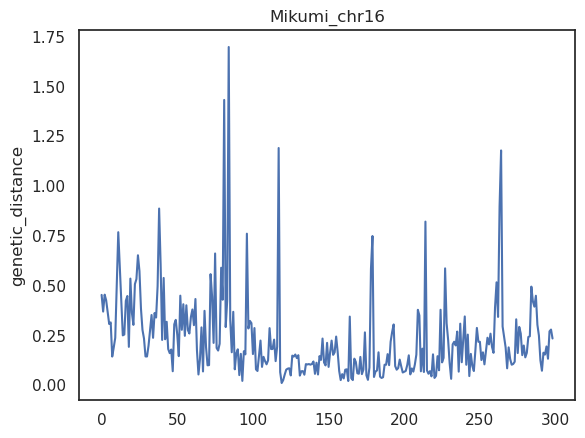

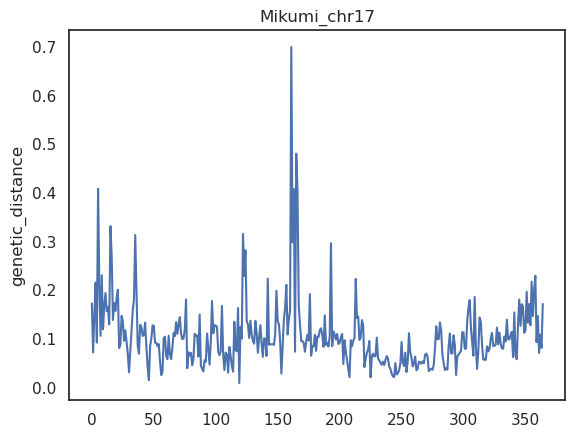

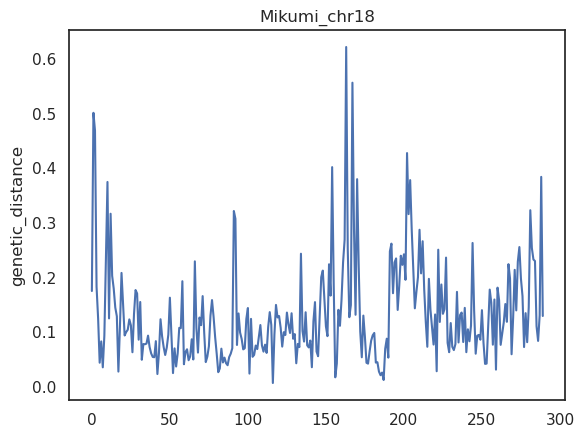

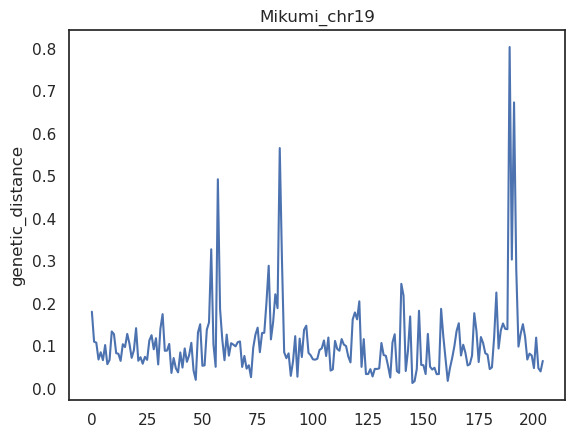

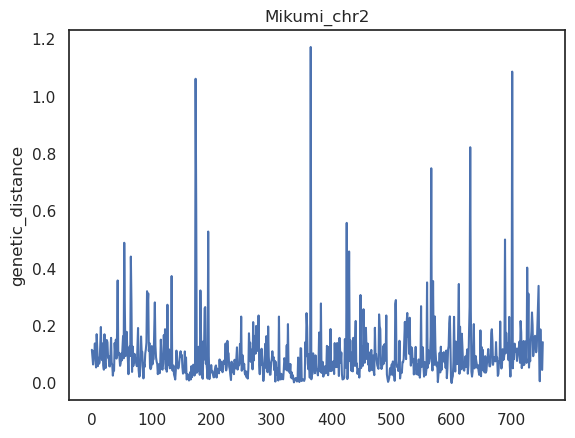

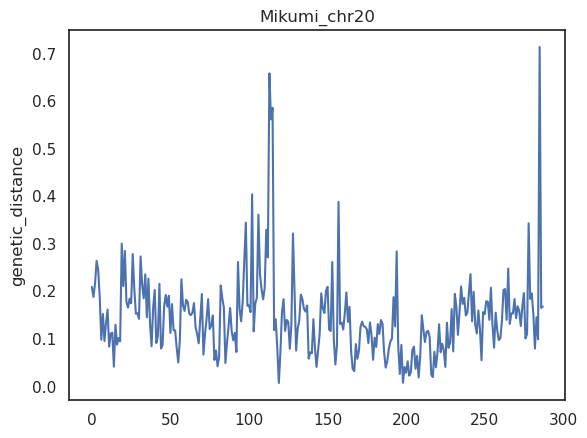

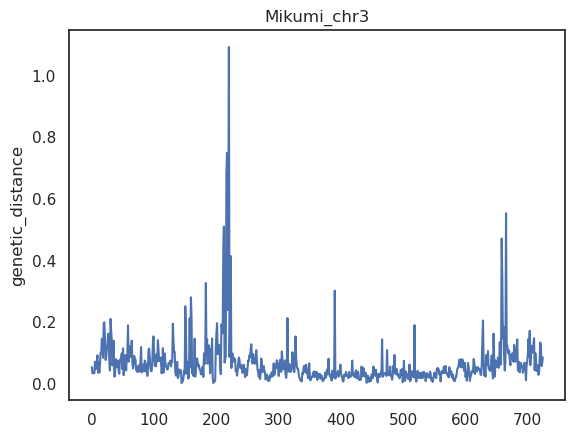

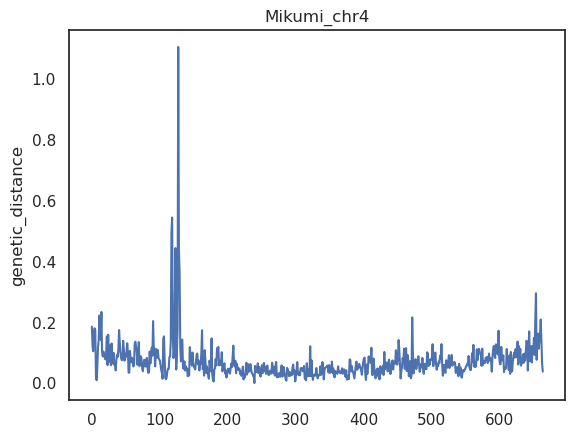

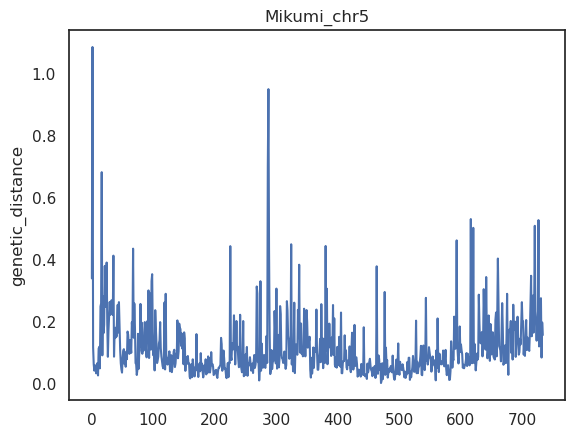

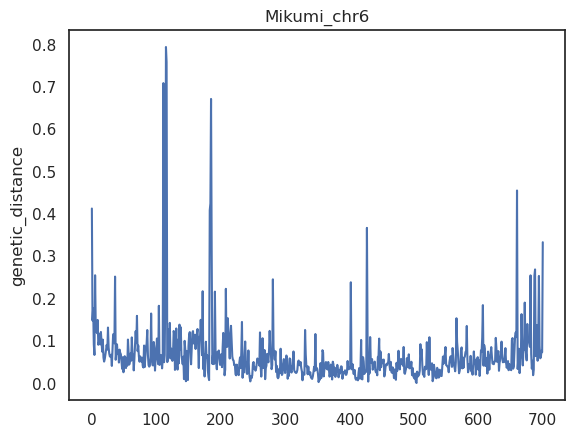

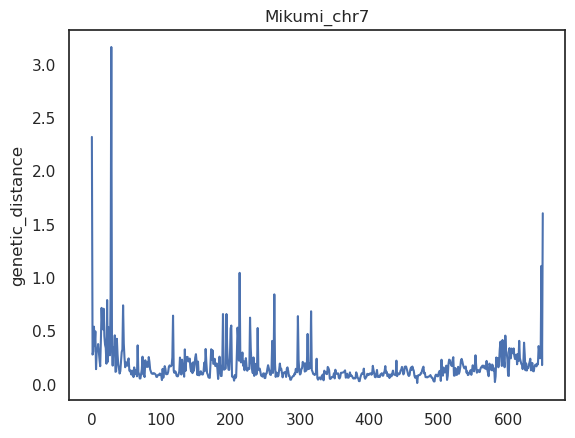

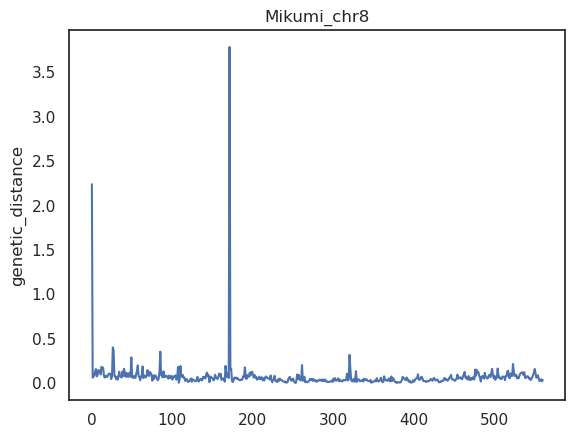

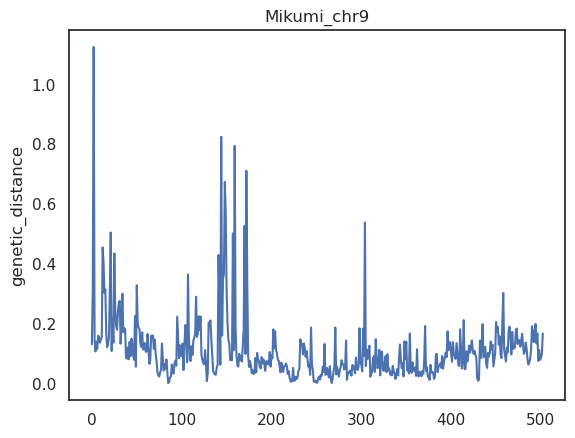

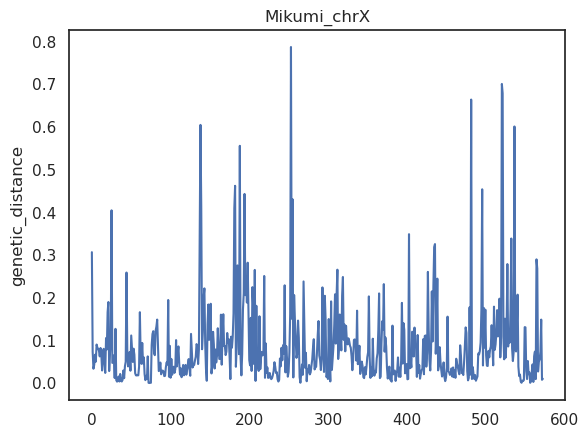

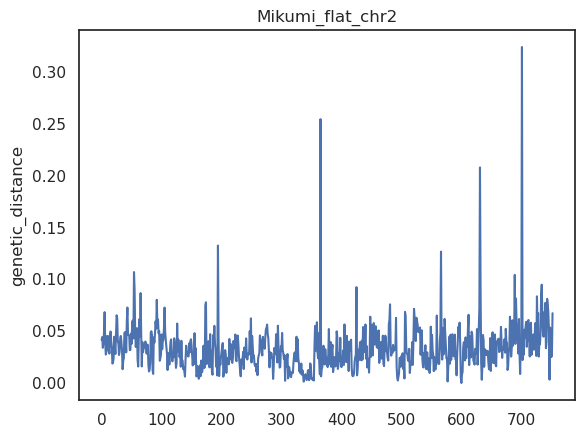

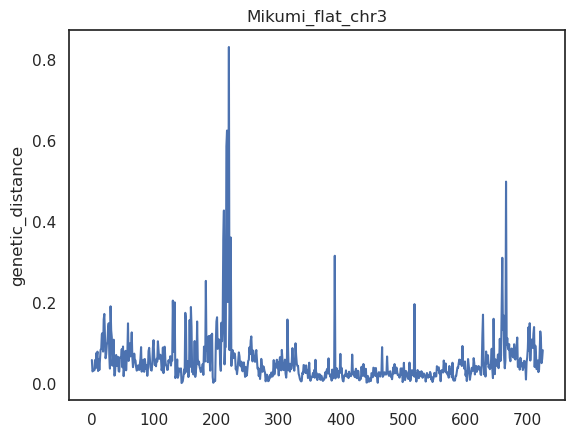

<Figure size 640x480 with 0 Axes>

In [78]:
window_size = 250000
for c in sorted(mikumi_recombs.chrom.unique()):
    print(c)
    chrom_df = mikumi_recombs.loc[(mikumi_recombs.chrom == c)]
    total_size = chrom_df.genetic_distance.sum()
    window_sums = chrom_df.groupby(pd.cut(chrom_df.start,np.arange\
                                          (0, chrom_df.start.max(), window_size))).sum().genetic_distance*100
    fig = sns.lineplot(y = window_sums,
                x = list(range(len(window_sums))))
    fig.set(title = "Mikumi_{}".format(c))
    plt.figure()

In [79]:
mikumi_recombs.chrom.unique()

array(['chr19', 'chr15', 'chr7', 'chr20', 'chr11', 'chr3', 'chr14',
       'chr6', 'chr10', 'chr2', 'chr18', 'chr16', 'chr4', 'chr12', 'chr8',
       'flat_chr2', 'chrX', 'chr9', 'flat_chr3', 'chr17', 'chr5', 'chr13',
       'chr1'], dtype=object)

chr2
flat_chr2


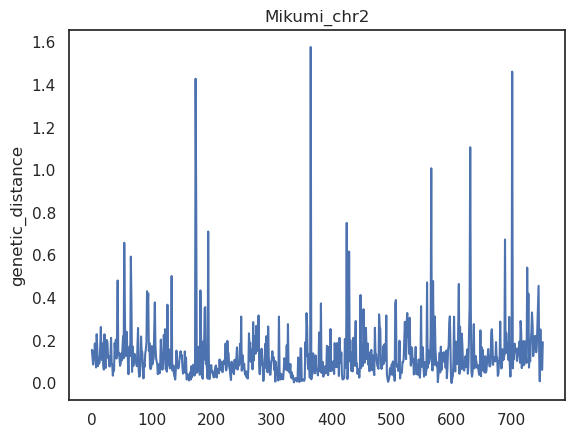

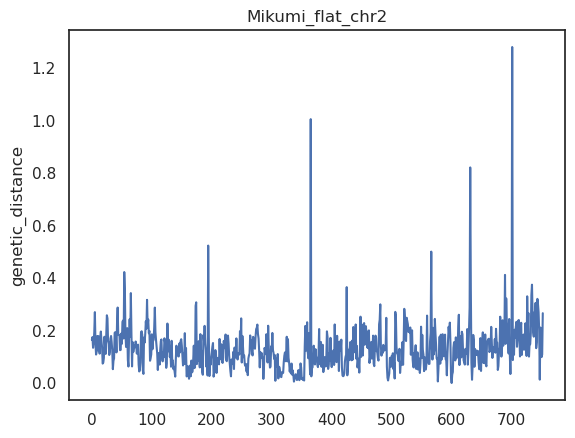

<Figure size 640x480 with 0 Axes>

In [82]:
window_size = 250000
for c in sorted(['chr2', 'flat_chr2']):
    print(c)
    chrom_df = mikumi_recombs.loc[(mikumi_recombs.chrom == c)]
    total_size = chrom_df.genetic_distance.sum()
    window_sums = chrom_df.groupby(pd.cut(chrom_df.start,np.arange\
                                          (0, chrom_df.start.max(), window_size))).sum().genetic_distance*100/total_size
    fig = sns.lineplot(y = window_sums,
                x = list(range(len(window_sums))))
    fig.set(title = "Mikumi_{}".format(c))
    plt.figure()